In [0]:
%matplotlib inline

In [0]:
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from fastai import *
from fastai.vision import *
from fastai.vision.image import *
import cv2
import torchvision
import os

In [0]:
TEST = Path('/content/human-protein-atlas-image-classification/test')
LABELS = Path('/content/human-protein-atlas-image-classification/train.csv')
SPLIT = Path('/content/human-protein-atlas-image-classification/protein-trainval-split')

In [0]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [19]:
# using a split that includes all classes in val
with open(os.path.join(str(SPLIT),'tr_names.txt'), 'r') as text_file:
    tr_n = text_file.read().split(',')
with open(os.path.join(str(SPLIT),'val_names.txt'), 'r') as text_file:
    val_n = text_file.read().split(',')
test_names = sorted({f[:36] for f in os.listdir(str(TEST))})
print(len(tr_n),len(val_n))

28575 2497


In [0]:
with open('/content/human-protein-atlas-image-classification/valid.txt', 'a') as f:
    for fname in val_n:
        f.write(fname+'.png'+'\n')

In [0]:
#creating duplicates for rare classes in train set
class Oversampling:
    def __init__(self,path):
        self.train_labels = pd.read_csv(path).set_index('Id')
        self.train_labels['Target'] = [[int(i) for i in s.split()] 
                                       for s in self.train_labels['Target']]  
        #set the minimum number of duplicates for each class
        self.multi = [1,1,1,1,1,1,1,1,
                      4,4,4,1,1,1,1,4,
                      1,1,1,1,2,1,1,1,
                      1,1,1,4]

    def get(self,image_id):
        labels = self.train_labels.loc[image_id,'Target'] if image_id \
          in self.train_labels.index else []
        m = 1
        for l in labels:
            if m < self.multi[l]: m = self.multi[l]
        return m
    
labels = pd.read_csv(LABELS)
s = Oversampling(LABELS)
for idx in tr_n:
        time = s.get(idx) - 1
        if time > 0:
            row = [labels[labels.Id==idx][0:1] for _ in range(time)]
            rows = pd.concat(row, copy=False)
            labels = pd.concat([labels, rows], copy=False)
label = labels.set_index('Id')
labels = label.reset_index()
labels.to_csv('/content/human-protein-atlas-image-classification/label.csv',
             header=True, index=False)

In [0]:
def open_4_channel(fname):
    fname = str(fname)
    suffix = '.png'
    # strip extension before adding color
    if fname.endswith('.png') or fname.endswith('.tif'):
        suffix = fname[-4:]
        fname = fname[:-4]

    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(fname+'_'+color+suffix, flags).astype(np.float32)/255
           for color in colors]
    
    x = np.stack(img, axis=-1)
    return Image(pil2tensor(x, np.float32))

In [0]:
RESNET_ENCODERS = {
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
}


class Resnet4Channel(nn.Module):
    def __init__(self, encoder_depth=34, pretrained=True, num_classes=28, mixup=False, copy_extra_channel=False, adjust_first_layer=False):
        super().__init__()

        encoder = RESNET_ENCODERS[encoder_depth](pretrained=pretrained)
        
        # we initialize this conv to take in 4 channels instead of 3
        # we keeping corresponding weights and initializing new weights with zeros
        # this trick taken from https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb
        w = encoder.conv1.weight
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        if copy_extra_channel:
            to_concat = w[:, :1, :, :].clone() 
        elif mixup:
            to_concat = 0.5*(w[:,:1,:,:].clone() + w[:,2:,:,:].clone())
        else:
            to_concat = torch.zeros(64,1,7,7)
        self.conv1.weight = nn.Parameter(torch.cat((w,to_concat),dim=1) * (0.75 if adjust_first_layer else 1.))
        
        self.bn1 = encoder.bn1
        self.relu = nn.ReLU(inplace=True) 
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = encoder.layer1
        self.layer2 = encoder.layer2
        self.layer3 = encoder.layer3
        self.layer4 = encoder.layer4
        
        self.avgpool = encoder.avgpool
        self.fc = nn.Linear(512 * (1 if encoder_depth==34 else 4), num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [24]:
path = Path('/content/human-protein-atlas-image-classification')
df = pd.read_csv(path/'label.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'label.csv', folder='train', suffix='.png')
       .split_by_fname_file(path/'valid.txt')
       .label_from_df(label_delim=' ', classes=[str(i) for i in range(28)]))

src.train.x.open = open_4_channel

src.valid.x.open = open_4_channel

In [26]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))
test_fnames = [path/'test'/test_id for test_id in test_ids]

src.add_test(test_fnames);
src.test.x.open = open_4_channel

test_fnames[:5]

[PosixPath('/content/human-protein-atlas-image-classification/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('/content/human-protein-atlas-image-classification/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('/content/human-protein-atlas-image-classification/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('/content/human-protein-atlas-image-classification/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('/content/human-protein-atlas-image-classification/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [0]:
imagenet_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

def get_data(sz, bs, length1, length2):
  tfms = [get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                         max_lighting=0.05, max_warp=0.)[0]+[cutout(n_holes=(2, 7), length=(length1, length2), p=0.75)],[ ]]
  data = (src.transform(tfms, size=sz)
          .databunch(bs=bs)
          .normalize(imagenet_stats))
  return data

In [0]:
data = get_data(256, 64, 20, 40)

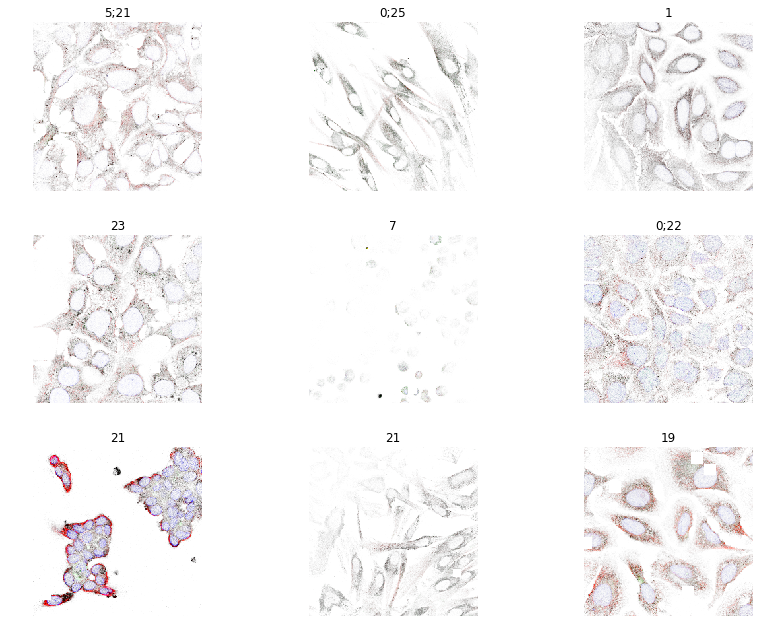

In [0]:
data.show_batch(rows=3, figsize=(12,9), ds_type=DatasetType.Train)

In [0]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)
  
def resnet34(pretrained):
    return Resnet4Channel(encoder_depth=34)

# copied from https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py
def _resnet_split(m): return (m[0][6], m[1])

f1_score = partial(fbeta, thresh=0.2)

In [0]:
learn = cnn_learner(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    metrics=[f1_score],
    model_dir="/content/drive/My Drive/CODE/pretein-fastai-1.x/data"
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


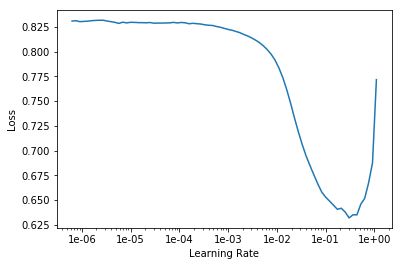

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 3e-2
learn.fit_one_cycle(1, slice(lr))
learn.save('stage--1--256')

epoch,train_loss,valid_loss,fbeta,time
0,0.121216,0.143996,0.559409,11:59


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


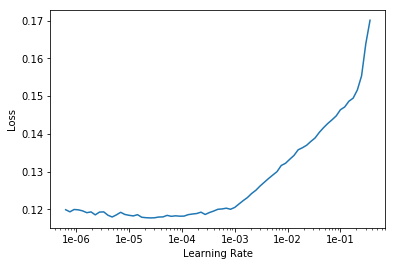

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(10, slice(2e-5, lr/5), pct_start=0.2)
learn.save('stage--2--256')

epoch,train_loss,valid_loss,fbeta,time
0,0.116382,0.143955,0.574570,12:22
1,0.112625,0.146540,0.589637,12:30
2,0.105618,0.146462,0.601831,12:28
3,0.097785,0.119587,0.676489,12:57
4,0.094090,0.117842,0.678808,12:58
5,0.089472,0.109608,0.709973,13:02
6,0.085166,0.105137,0.720423,13:07
7,0.081592,0.103295,0.725604,12:43
8,0.076796,0.101070,0.732362,13:17
9,0.075410,0.100545,0.734277,12:59


In [0]:
learn = None
gc.collect()

In [0]:
# get biger
data = get_data(512, 32, 40, 80)

In [0]:
learn = cnn_learner(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    metrics=[f1_score],
    model_dir="/content/drive/My Drive/CODE/pretein-fastai-1.x/data"
).load('stage--2--256');
learn.to_fp16();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


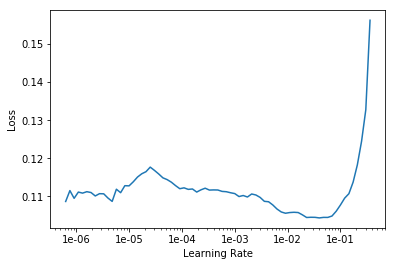

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-2
learn.fit_one_cycle(5, slice(lr))
learn.save('stage--1--512')

epoch,train_loss,valid_loss,fbeta,time
0,0.085064,0.105243,0.725985,23:43
1,0.089584,0.107068,0.729084,23:39
2,0.081455,0.097697,0.748379,24:39
3,0.075880,0.093873,0.757883,24:28
4,0.072406,0.092505,0.762379,23:52


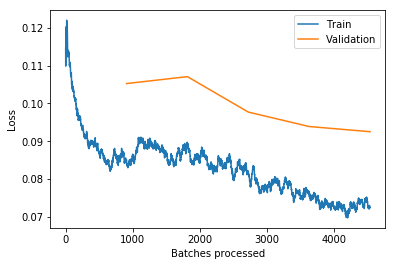

In [0]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


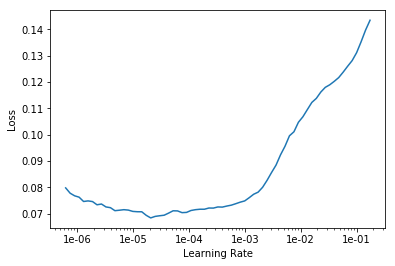

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-2
learn.fit_one_cycle(5, slice(1e-5, lr/20), wd=(1e-3,1e-3,1e-1))
learn.save('stage--2--512')

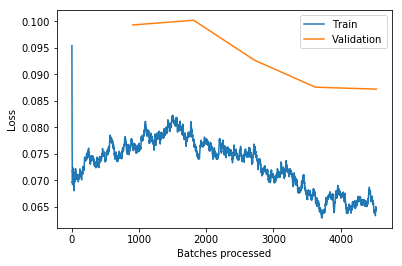

In [0]:
learn.recorder.plot_losses()

In [0]:
preds,_ = learn.get_preds(DatasetType.Test)
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv('/content/drive/My Drive/CODE/pretein-fastai-1.x/submission2_1.csv', header=True, index=False)